# Machine Learning on Walking Activity Detection in PD patients

## 0. Initialization

### 0.1 Imports

In [1]:
import pandas as pd
import numpy as np
from scipy import signal
import tensorflow as tf
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from tensorflow.keras.optimizers import SGD, Adagrad
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM, TimeDistributed
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from matplotlib import pyplot as plt
from functools import partial
import os

### 0.2 Processing Functions

In [3]:
def resample_data(df, frequency):
    dx = np.zeros(len(df))
    dy = np.zeros(len(df))
    dz = np.zeros(len(df))
    xSlope = np.zeros(len(df))
    ySlope = np.zeros(len(df))
    zSlope = np.zeros(len(df))
    xIntercept = np.zeros(len(df))
    yIntercept = np.zeros(len(df))
    zIntercept = np.zeros(len(df))

    new_x = []
    new_y = []
    new_z = []

    for i in range(1, len(df)):
        dtime = df.loc[i, 0] - df.loc[i-1, 0]
        dx[i] = df.loc[i, 1] - df.loc[i-1, 1]
        dy[i] = df.loc[i, 2] - df.loc[i-1, 2]
        dz[i] = df.loc[i, 3] - df.loc[i-1, 3]
        xSlope[i] = dx[i] / dtime
        ySlope[i] = dy[i] / dtime
        zSlope[i] = dz[i] / dtime
        xIntercept[i] = df.loc[i, 1]
        yIntercept[i] = df.loc[i, 2]
        zIntercept[i] = df.loc[i, 3]

    df_new = pd.DataFrame()

    time = list(np.around(np.arange(df.loc[0,0], df.loc[len(df)-1, 0], 1/frequency), 2))

    best_j = 0
    for i in range(len(time)):
        best_value = float("inf")
        j = best_j
        for _ in range(15):
            if j == len(df):
                break
            diff = df.loc[j, 0] - time[i]
            if diff > 0.15:
                break

            if abs(diff) < best_value:
                best_value = abs(diff)
                best_j = j
            j+=1
        timeI = time[i] - df.loc[best_j, 0]

        best_value = df.loc[best_j, 0] - time[i]
        new_x.append(xSlope[best_j] * best_value + xIntercept[best_j])
        new_y.append(ySlope[best_j] * best_value + yIntercept[best_j])
        new_z.append(zSlope[best_j] * best_value + zIntercept[best_j])
    
    df_new[0] = time
    df_new[1] = new_x
    df_new[2] = new_y
    df_new[3] = new_z
    return df_new


def butter_bandpass(cut, fs, order, btype):
    """
    A function which created a filter. It can be a bandpass,
    lowpass or highpass filter to apply for signal.
    It makes use of the signal class of the scipy package.
        *cut: frequency value which will serve to cut the signal
        *fs: frequency of the signal
        *order: from 1 to N it changes the way the signal is filtered
        *btype: 'bandpass', 'low' or 'high'
    """
    nyq = 0.5 * fs
    high_low = cut / nyq
    b, a = signal.butter(order, high_low, btype)
    return b, a


def butter_bandpass_filter(data, cut, fs, order=4, btype="low"):
    """
    This function employs the butter_bandpass to a dataset.
    It has some default values which are mainly used in this project.
    """
    b, a = butter_bandpass(cut, fs, order, btype)
    y = signal.filtfilt(b, a, data)
    return y


def butter_bp_data(data, lower_than, fs, order, btype):
    """
    This function applies the bandpass to a dataset
    with 4 dimensions, supposing that the 1st is the time dimension.
    """
    for i in range(1, 4):
        data[i] = butter_bandpass_filter(data[i], lower_than, fs, order, btype)
    return data


def applyOffsetRemove(df):
    df[1] = np.subtract(df[1], np.average(df[1]))
    df[2] = np.subtract(df[2], np.average(df[2]))
    df[3] = np.subtract(df[3], np.average(df[3]))

## 1 Processing data

This section will consist of several parts

+ Resample the data to 10Hz (Check)
+ The data must start at first timestamp and stop at last timestamp (Check)
+ Analysing if data should be normalized
+ Data goes to .csv and anonimized

To start I open the Timestamps CSV which contains the timestamps of start and end when the patient was walking.

In [4]:
file_ts = "data/TS@P1.csv"

df_ts = pd.read_csv(file_ts)

start = df_ts.loc[0, 'Timestamp S']
end = df_ts.loc[len(df_ts)-1, 'Timestamp E']

df_ts.head()

,Timestamp S,Timestamp E,From,To,Seconds S,Seconds E
0,1561983739,1561983747,00:02:21,00:02:29,0,8
1,1561983768,1561983776,00:02:50,00:02:58,29,8
2,1561983784,1561983791,00:03:06,00:03:13,45,7
3,1561983807,1561983817,00:03:29,00:03:39,68,10
4,1561983831,1561983842,00:03:53,00:04:04,92,11


The only values we want from this CSV are the 'Timestamp S' and 'Timestamp E'. They are the timestamps for starting and ending a walking segment.

I will load the dataset for patient 1, resample it to 10Hz instead of 100Hz and cut the DataFrame on the starting timestamp and ending timestamp since there might exist movements associated with walking that were not observed in the timestamps CSV.

In [5]:
file = file_ts.split("@")[1]
df = pd.read_csv("data/" + file, header=None)
df = df[(df[0] > start) & (df[0] < end)].reset_index(drop=True)
df = resample_data(df, 33)

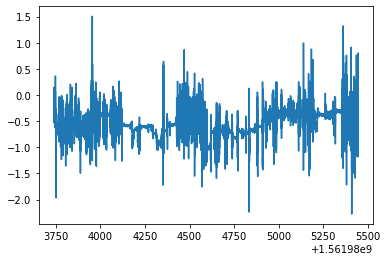

In [6]:
plt.plot(df[0], df[1])

As we can see there is a lot of noise in the data, including the effect of gravity on this axis, justifying why the data is centered around -0.5g.

To improve the data for classification, we remove this offset and apply a Butterworth filter to eliminate all movements above 0.5Hz. By applying this filter we are not allowing for the detection of any step that takes more than 2 seconds.

In [7]:
applyOffsetRemove(df)
df = butter_bp_data(df, 0.5, 10, 4, 'high')

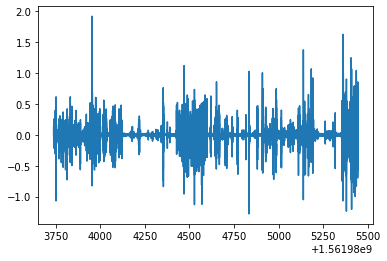

In [8]:
plt.plot(df[0], df[1])

In [9]:
# What are the max and the minimum values of this dataset?

print(f"Maximum value for x-axis is: {df[1].quantile(0.999):.3}")
print(f"Minimum value for x-axis is: {df[1].quantile(0.001):.3}")
print(f"Maximum value for y-axis is: {df[2].quantile(0.999):.3}")
print(f"Minimum value for y-axis is: {df[2].quantile(0.001):.3}")
print(f"Maximum value for z-axis is: {df[3].quantile(0.999):.3}")
print(f"Minimum value for z-axis is: {df[3].quantile(0.001):.3}")

Maximum value for x-axis is: 0.602
Minimum value for x-axis is: -0.609
Maximum value for y-axis is: 0.637
Minimum value for y-axis is: -0.466
Maximum value for z-axis is: 0.456
Minimum value for z-axis is: -0.467


To understand if it is needed to normalize the data, the max and min values will be compared across 4 datasets. The first one is above, but I will check as well for 3 more files: P2, P3, P5.

In [30]:
def check_max_min_values(*args):
    for arg in args:
        file_ts = "data/TS@" + arg + ".csv"
        df_ts = pd.read_csv(file_ts)
        start = df_ts.loc[0, 'Timestamp S']
        end = df_ts.loc[len(df_ts)-1, 'Timestamp E']
        file = file_ts.split("@")[1]
        df = pd.read_csv("data/" + file, header=None)
        df = df[(df[0] > start) & (df[0] < end)].reset_index(drop=True)
        df = resample_data(df, 33)
        applyOffsetRemove(df)
        df = butter_bp_data(df, 0.5, 10, 4, 'high')
        print(f"Maximum value for {arg} x-axis is: {df[1].quantile(0.999):.3}")
        print(f"Minimum value for {arg} x-axis is: {df[1].quantile(0.001):.3}")
        print(f"Maximum value for {arg} y-axis is: {df[2].quantile(0.999):.3}")
        print(f"Minimum value for {arg} y-axis is: {df[2].quantile(0.001):.3}")
        print(f"Maximum value for {arg} z-axis is: {df[3].quantile(0.999):.3}")
        print(f"Minimum value for {arg} z-axis is: {df[3].quantile(0.001):.3}")

In [31]:
files = ["P2", "P3", "P5"]
check_max_min_values(*files)

Maximum value for P2 x-axis is: 0.334
Minimum value for P2 x-axis is: -0.389
Maximum value for P2 y-axis is: 0.327
Minimum value for P2 y-axis is: -0.402
Maximum value for P2 z-axis is: 0.266
Minimum value for P2 z-axis is: -0.294
Maximum value for P3 x-axis is: 0.345
Minimum value for P3 x-axis is: -0.394
Maximum value for P3 y-axis is: 0.211
Minimum value for P3 y-axis is: -0.237
Maximum value for P3 z-axis is: 0.373
Minimum value for P3 z-axis is: -0.314
Maximum value for P5 x-axis is: 0.495
Minimum value for P5 x-axis is: -0.491
Maximum value for P5 y-axis is: 0.357
Minimum value for P5 y-axis is: -0.489
Maximum value for P5 z-axis is: 0.381
Minimum value for P5 z-axis is: -0.321


Data seems to not need any normalization since it is mostly varying between -0.4 and 0.4 in all the 3 axis. To get these values, a quantile of 99.9% and 0.1% were used in order to leave out the outlier movements.

## 2. Preparing Dataset for Classifiers

Preparing the dataset implied creating the target variable by using the observed timestamps. The features used for the algorithms will be all the acceleration values 0.5sec to the left and right of a given sample.

Here we have:

+ Adding the target variable
+ Creating the Numpy arrays and saving them
    + One array for the TLFN
    + Another for the LSTM Network

In [120]:
def add_target(df, df_ts):
    for i in df_ts.index:
        start, end = df_ts.loc[i,['Timestamp S', 'Timestamp E']].values
        df[f"target {i}"] = df[0].apply(lambda x: 1 if ((x > start) & (x < end)) else 0)
    df["target"] = df.loc[:,"target 0":f"target {len(df_ts)-1}"].sum(axis=1)
    columns = [0, 1, 2, 3, "target"]
    return df[columns]
    

def create_X_y(df, window = 30):
    X = np.full((len(df[0]), window*3), -50, dtype=float)

    for i in range(int(window/2), len(df)-int(window/2)):
        X[i] = df[[1,2,3]][int(i-window/2):int(i+window/2)].values.reshape(1,-1)[0]

    y = np.asmatrix(df['target']).T
    data = np.hstack((X,y))
    data = data[int(window/2):-int(window/2)]
    return data


def create_X_y_lstm(df, window = 30):
    X = np.full((len(df[0]), window, 3), -50, dtype=float)
    y = np.full((len(df[0]), window, 1), -1, dtype=float)
    
    for i in range(int(window/2), len(df)-int(window/2)):
        X[i] = df[[1,2,3]][int(i-window/2):int(i+window/2)].values
        y[i] = df[['target']][int(i-window/2):int(i+window/2)].values.reshape(-1,1)
            
    data = np.concatenate((X,y), axis=2)
    data = data[int(window/2):-int(window/2)]
    return data
    

In [41]:
df = add_target(df, df_ts)
df.head()

,0,1,2,3,target
0,1.561984e+09,0.001066,-0.006039,-0.001764,1
1,1.561984e+09,0.137257,0.725025,-0.278115,1
2,1.561984e+09,-0.010036,0.492054,-0.147995,1
3,1.561984e+09,-0.060234,0.308295,-0.090331,1
4,1.561984e+09,-0.056496,0.155705,-0.069158,1


In [42]:
df['target'].value_counts()

0    49137
1     7161
Name: target, dtype: int64

In [43]:
df_path = os.path.join("data", f"P1_p.npy")

if not os.path.isfile(df_path):
    data = create_X_y(df)
else:
    data = np.load(df_path)

In [44]:
print(f"This dataset has {data.shape[0]} entries and {data.shape[1]-1} features")

This dataset has 56268 entries and 90 features


In [11]:
df_path_2 = os.path.join("data", f"P1_p_lstm.npy")

if not os.path.isfile(df_path_2):
    data = create_X_y_lstm(df)
else:
    data = np.load(df_path_2)

In [14]:
print(f"This dataset has {data.shape[0]} entries, {data.shape[1]} timesteps and {data.shape[2]-1} features per timestep.")

This dataset has 56268 entries, 30 timesteps and 3 features per timestep.


It was managed to create the target variable and testing creating an array the arrays for the TLFN and LSTM.

### 2.1 Preparing files for all patients

#### Files for TLFN

In [10]:
files = [f"P{n}" for n in range(1,17)]
files.remove("P4") # Had to be removed due to problems in timestamps

In [4]:
def process_data(*args):
    for arg in args:
        df_path = os.path.join("data", f"{arg}_p.npy")
        if not os.path.isfile(df_path):
            file_ts = "data/TS@" + arg + ".csv"
            df_ts = pd.read_csv(file_ts)
            start = df_ts.loc[0, 'Timestamp S']
            end = df_ts.loc[len(df_ts)-1, 'Timestamp E']
            file = file_ts.split("@")[1]
            df = pd.read_csv("data/" + file, header=None)
            df = df[(df[0] > start) & (df[0] < end)].reset_index(drop=True)
            df = resample_data(df, 33)
            applyOffsetRemove(df)
            df = butter_bp_data(df, 0.5, 10, 4, 'high')
            df = add_target(df, df_ts)
            df = create_X_y(df)
            np.save(df_path, df)
            print(f"Dataset {arg} has {df.shape[0]} entries and {df.shape[1]-1} features")
        else:
            df = np.load(df_path)
            print(f"Dataset {arg} has {df.shape[0]} entries and {df.shape[1]-1} features")

In [5]:
process_data(*files)

Dataset P1 has 56268 entries and 90 features
Dataset P2 has 43827 entries and 90 features
Dataset P3 has 33729 entries and 90 features
Dataset P5 has 38679 entries and 90 features
Dataset P6 has 54288 entries and 90 features
Dataset P7 has 64023 entries and 90 features
Dataset P8 has 45609 entries and 90 features
Dataset P9 has 55542 entries and 90 features
Dataset P10 has 72273 entries and 90 features
Dataset P11 has 92898 entries and 90 features
Dataset P12 has 39636 entries and 90 features
Dataset P13 has 64518 entries and 90 features
Dataset P14 has 61647 entries and 90 features
Dataset P15 has 50229 entries and 90 features
Dataset P16 has 25248 entries and 90 features


#### Files for LSTM

In [122]:
def process_data_lstm(*args):
    for arg in args:
        df_path = os.path.join("data", f"{arg}_p_lstm.npy")
        if not os.path.isfile(df_path):
            file_ts = "data/TS@" + arg + ".csv"
            df_ts = pd.read_csv(file_ts)
            start = df_ts.loc[0, 'Timestamp S']
            end = df_ts.loc[len(df_ts)-1, 'Timestamp E']
            file = file_ts.split("@")[1]
            df = pd.read_csv("data/" + file, header=None)
            df = df[(df[0] > start) & (df[0] < end)].reset_index(drop=True)
            df = resample_data(df, 33)
            applyOffsetRemove(df)
            df = butter_bp_data(df, 0.5, 10, 4, 'high')
            df = add_target(df, df_ts)
            df = create_X_y_lstm(df)
            np.save(df_path, df)
            print(f"Dataset {arg} has {df.shape[0]} samples, {df.shape[1]} timesteps and {df.shape[2]-1} features")
        else:
            df = np.load(df_path)
            print(f"Dataset {arg} has {df.shape[0]} samples, {df.shape[1]} timesteps and {df.shape[2]-1} features")

In [124]:
process_data_lstm(*files)

Dataset P1 has 56268 samples, 30 timesteps and 4 features
Dataset P2 has 43827 samples, 30 timesteps and 4 features
Dataset P3 has 33729 samples, 30 timesteps and 4 features
Dataset P5 has 38679 samples, 30 timesteps and 4 features
Dataset P6 has 54288 samples, 30 timesteps and 4 features
Dataset P7 has 64023 samples, 30 timesteps and 4 features
Dataset P8 has 45609 samples, 30 timesteps and 4 features
Dataset P9 has 55542 samples, 30 timesteps and 4 features
Dataset P10 has 72273 samples, 30 timesteps and 4 features
Dataset P11 has 92898 samples, 30 timesteps and 4 features
Dataset P12 has 39636 samples, 30 timesteps and 4 features
Dataset P13 has 64518 samples, 30 timesteps and 4 features
Dataset P14 has 61647 samples, 30 timesteps and 4 features
Dataset P15 has 50229 samples, 30 timesteps and 4 features
Dataset P16 has 25248 samples, 30 timesteps and 4 features


### 2.1 Checking results

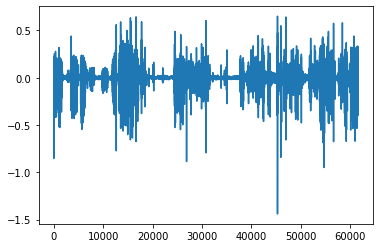

In [15]:
data = np.load('data/P14_p.npy')
plt.plot(list(range(len(data))), data[:,1])

In [16]:
print('Processed dataset shape %s' % Counter(data[:,-1]))

Processed dataset shape Counter({0.0: 47937, 1.0: 13710})


## 3. Loading Data

### 3.1 Load Data for DNN

In [22]:
p1 = np.load("data/P1_p.npy")
p2 = np.load("data/P2_p.npy")
p3 = np.load("data/P3_p.npy")
p5 = np.load("data/P5_p.npy")
p6 = np.load("data/P6_p.npy")
p7 = np.load("data/P7_p.npy")
p8 = np.load("data/P8_p.npy")
p9 = np.load("data/P9_p.npy")
p10 = np.load("data/P10_p.npy")
p11 = np.load("data/P11_p.npy")
p12 = np.load("data/P12_p.npy")
p13 = np.load("data/P13_p.npy")
p14 = np.load("data/P14_p.npy")
p15 = np.load("data/P15_p.npy")
p16 = np.load("data/P16_p.npy")

### 3.1.1 Concatenating Training and Test set

In [23]:
def train_test_Xy(train_tuple, test_tuple):
    data_train = np.empty(train_tuple[0].shape[1], dtype=float).reshape(1,-1)
    data_test = np.empty(train_tuple[0].shape[1], dtype=float).reshape(1,-1)
    for array in train_tuple:
        data_train = np.concatenate((data_train, array))
    for array in test_tuple:
        data_test = np.concatenate((data_test, array))
    return data_train[1:], data_test[1:]

In [24]:
# This is an example of how the function works

data_train, data_test = train_test_Xy([p1, p2, p3, p5, p6, p7, p8, p9, p10, p11, p12, p13, p14, p15, p16], [p6])
print(f"Train data shape is {data_train.shape}")
print(f"Test data shape is {data_test.shape}")

Train data shape is (798414, 91)
Test data shape is (54288, 91)


### 3.2 Load Data for LTSM

In [16]:
p1 = np.load("data/P1_p_lstm.npy")
p2 = np.load("data/P2_p_lstm.npy")
p3 = np.load("data/P3_p_lstm.npy")
p5 = np.load("data/P5_p_lstm.npy")
p6 = np.load("data/P6_p_lstm.npy")
p7 = np.load("data/P7_p_lstm.npy")
p8 = np.load("data/P8_p_lstm.npy")
p9 = np.load("data/P9_p_lstm.npy")
p10 = np.load("data/P10_p_lstm.npy")
p11 = np.load("data/P11_p_lstm.npy")
p12 = np.load("data/P12_p_lstm.npy")
p13 = np.load("data/P13_p_lstm.npy")
p14 = np.load("data/P14_p_lstm.npy")
p15 = np.load("data/P15_p_lstm.npy")
p16 = np.load("data/P16_p_lstm.npy")

### 3.2.1 Concatenating Training and Test set

In [4]:
def train_test_Xy_lstm(train_tuple, test_tuple):
    data_train = np.empty((1, (train_tuple)[0].shape[1], (train_tuple)[0].shape[2]), dtype=float)
    data_test = np.empty((1, (train_tuple)[0].shape[1], (train_tuple)[0].shape[2]), dtype=float)
    for array in train_tuple:
        data_train = np.concatenate((data_train, array))
    for array in test_tuple:
        data_test = np.concatenate((data_test, array))
    return data_train[1:], data_test[1:]

In [5]:
# This is an example of how the function works

data_train, data_test = train_test_Xy_lstm([p1, p2], [p6])
print(f"Train data shape is {data_train.shape}")
print(f"Test data shape is {data_test.shape}")

Train data shape is (100095, 30, 4)
Test data shape is (54288, 30, 4)


## 4. Balancing the Data

We have unbalanced data so undersampling was prefered due to the high volume of data. 

RandomUnderSampler is used since we want a well distributed decrease in number of samples.

In [26]:
print('Original dataset shape %s' % Counter(data_train[:,-1]))

Original dataset shape Counter({0.0: 559015, 1.0: 109634})


In [27]:
rus = RandomUnderSampler()
X_train, y_train = rus.fit_resample(data_train[:,:-1], data_train[:,-1])
print('Resampled dataset shape %s' % Counter(y_train))

Resampled dataset shape Counter({0.0: 109634, 1.0: 109634})


## 5. Important Functions

In [ ]:
# These functions are used in order to identify the best model during training

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## 6. Applying a Deep Learning to training and test set

### 6.1 DNN

#### 6.1.1 Model

First we create the algorithm

In [30]:
def DNN(file, X_train, X_test, y_train, y_test):
    model_path = os.path.join('models', f'{file}_dnn.h5')
    history_path = os.path.join('models', f'{file}_dnn.csv')
    
    if not os.path.isfile(model_path) or not os.path.isfile(history_path):
        model = Sequential()
        model.add(Dense(200, input_shape=(90,), activation='relu', kernel_constraint=tf.keras.constraints.max_norm(3.)))
        model.add(Dropout(0.5))
        model.add(Dense(200, input_shape=(200,), activation='relu', kernel_constraint=tf.keras.constraints.max_norm(3.)))
        model.add(Dropout(0.5))
        model.add(Dense(200, input_shape=(200,), activation='relu', kernel_constraint=tf.keras.constraints.max_norm(3.)))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))

        initial_learning_rate=0.1
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate,
            decay_steps=100000,
            decay_rate=0.96,
            staircase=True)

        opt = SGD(learning_rate=lr_schedule, momentum=0.5)

        model.compile(
            optimizer=opt,
            loss='binary_crossentropy',
            metrics=['accuracy', f1_m],
        )

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)
        mc = ModelCheckpoint(model_path, monitor='val_f1_m', mode='max', verbose=0, save_best_only=True)

        history = model.fit(
            x=X_train,
            y=y_train,
            batch_size=100,
            epochs=50,
            verbose=1,
            validation_split=0.1,
            callbacks=[es, mc],
        )
        history = pd.DataFrame(history.history)
        history.to_csv(history_path)
    
    history = pd.read_csv(history_path)
    model = load_model(model_path, custom_objects={'f1_m': f1_m})

    # evaluate the model
    yhat_train = (model.predict(X_train, batch_size=50, verbose=0) > 0.5).astype("int32")
    yhat_test = (model.predict(X_test, batch_size=50, verbose=0) > 0.5).astype("int32")
    
    # accuracy: (tp + tn) / (p + n)
    train_acc = accuracy_score(y_train, yhat_train)
    test_acc = accuracy_score(y_test, yhat_test)
    # precision tp / (tp + fp)
    train_precision = precision_score(y_train, yhat_train)
    test_precision = precision_score(y_test, yhat_test)
    # recall: tp / (tp + fn)
    train_recall = recall_score(y_train, yhat_train)
    test_recall = recall_score(y_test, yhat_test)
    # f1: 2 tp / (2 tp + fp + fn)
    train_f1_score = f1_score(y_train, yhat_train)
    test_f1_score = f1_score(y_test, yhat_test)
    
    return history['loss'], history['val_loss'], train_acc, test_acc, train_f1_score, test_f1_score, train_precision, test_precision, train_recall, test_recall

#### 6.1.2 Patient KFold

This test consists on using all patients except one for training, and testing on that last one. All patients end up being used as test once.

In [31]:
files = [f"all-one-test/P{n}" for n in range(1,17)]
files.remove("all-one-test/P4") # Had to be removed due to problems in timestamps
files.remove("all-one-test/P7") # Had to be removed since the person uses support for walking

Train 0: 0.816, Test all-one-test/P1: 0.808
Train 1: 0.821, Test all-one-test/P2: 0.775
Train 2: 0.828, Test all-one-test/P3: 0.867
Train 3: 0.820, Test all-one-test/P5: 0.690
Train 4: 0.502, Test all-one-test/P6: 0.218
Train 5: 0.822, Test all-one-test/P8: 0.784
Train 6: 0.812, Test all-one-test/P9: 0.836
Train 7: 0.814, Test all-one-test/P10: 0.903
Train 8: 0.825, Test all-one-test/P11: 0.695
Train 9: 0.817, Test all-one-test/P12: 0.780
Train 10: 0.819, Test all-one-test/P13: 0.824
Train 11: 0.813, Test all-one-test/P14: 0.840
Train 12: 0.833, Test all-one-test/P15: 0.774
Train 13: 0.816, Test all-one-test/P16: 0.838


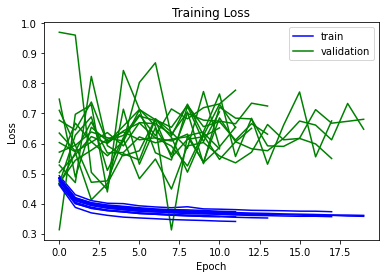

In [32]:
all_train_acc = list()
all_test_acc = list()
all_train_f1 = list()
all_test_f1 = list()
all_train_precision = list()
all_test_precision = list()
all_train_recall = list()
all_test_recall = list()

for i in range(14):
    datasets = [p1, p2, p3, p5, p6, p8, p9, p10, p11, p12, p13, p14, p15, p16]
    data_test = [datasets[i]]
    del datasets[i]
    
    data_train, data_test = train_test_Xy(datasets, data_test)
    
    rus = RandomUnderSampler()
    X_res, y_res = rus.fit_resample(data_train[:,:-1], data_train[:,-1])
    
    
    loss, val_loss, train_acc, test_acc, train_f1_score, test_f1_score, train_precision, test_precision, train_recall, test_recall = DNN(files[i], X_res, data_test[:,:-1], y_res, data_test[:,-1])
    
    all_train_acc.append(train_acc)
    all_test_acc.append(test_acc)
    all_train_f1.append(train_f1_score)
    all_test_f1.append(test_f1_score)
    all_train_precision.append(train_precision)
    all_test_precision.append(test_precision)
    all_train_recall.append(train_recall)
    all_test_recall.append(test_recall)

    # plot training history
    plt.plot(loss, label='train', color='b')
    plt.plot(val_loss, label='validation', color='g')
        
    print(f'Train {i}: {train_acc:.3f}, Test {files[i]}: {test_acc:.3f}')
    
plt.title('Training Loss')
plt.legend(['train', 'validation'])
plt.savefig('images/TrainingLoss.pdf')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

The algorithm tends to overfit right after. With the dropout and contraint on the norm of the weights, some better results are attained with the validation set in future epochs, but this is rare.

In [33]:
measures = [
    'Train Accuracy',
    'Test Accuracy',
    'Train Precision Score', 
    'Test Precision Score',
    'Train Recall Score',
    'Test Recall Score',
    'Train F1 Score',
    'Test F1 Score'
]
all_lists = [all_train_acc, all_test_acc, all_train_precision, all_test_precision, all_train_recall, all_test_recall, all_train_f1, all_test_f1]

for i in range(0, len(all_lists), 2):
    print(f"Average {measures[i]} = {np.array(all_lists[i]).mean():.3} +- {np.array(all_lists[i]).std():.3}")
    
print("====================")    

for i in range(1, len(all_lists)+1, 2):
    print(f"Average {measures[i]} = {np.array(all_lists[i]).mean():.3} +- {np.array(all_lists[i]).std():.3}")

Average Train Accuracy = 0.797 +- 0.0821
Average Train Precision Score = 0.797 +- 0.0842
Average Train Recall Score = 0.832 +- 0.0501
Average Train F1 Score = 0.808 +- 0.0416
Average Test Accuracy = 0.76 +- 0.161
Average Test Precision Score = 0.483 +- 0.202
Average Test Recall Score = 0.814 +- 0.144
Average Test F1 Score = 0.564 +- 0.145


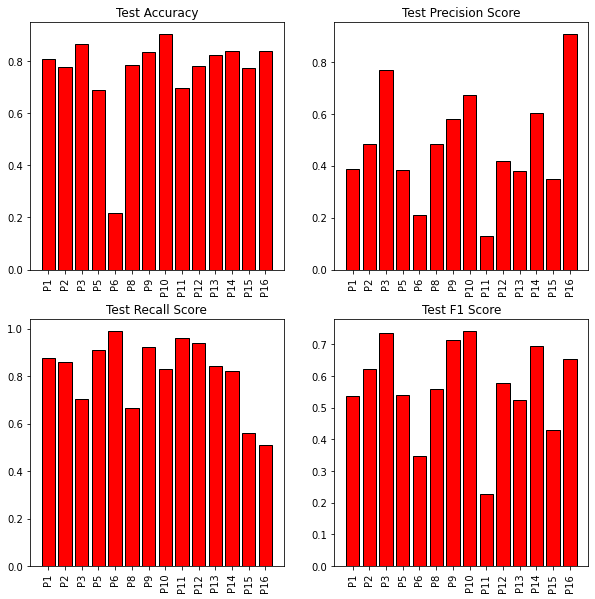

In [19]:
files = [f"P{n}" for n in range(1,17)]
files.remove("P4")
files.remove("P7")
plt.figure(figsize=(10, 10))
for i, j in enumerate(list(range(1,len(all_lists)+1,2))):
    plt.subplot(2,2,i+1)
    plt.bar(files, all_lists[j], color='r', edgecolor='black')
    plt.title(measures[j])
    plt.xticks(rotation=90)
plt.savefig('images/scoreboard.pdf')
plt.show()

---

#### 6.1.3 Individual Patient Train-Test

In this example, the algorithm Trains with the first 2/3 of a patient data and then it tests on the last 1/3. All patients were tested.

In [20]:
files = [f"one-one-test/P{n}" for n in range(1,17)]
files.remove("one-one-test/P4") # Had to be removed due to problems in timestamps
files

['one-one-test/P1',
 'one-one-test/P2',
 'one-one-test/P3',
 'one-one-test/P5',
 'one-one-test/P6',
 'one-one-test/P7',
 'one-one-test/P8',
 'one-one-test/P9',
 'one-one-test/P10',
 'one-one-test/P11',
 'one-one-test/P12',
 'one-one-test/P13',
 'one-one-test/P14',
 'one-one-test/P15',
 'one-one-test/P16']

Train 0: 0.869, Test one-one-test/P1: 0.855
Train 1: 0.572, Test one-one-test/P2: 0.279
Train 2: 0.876, Test one-one-test/P3: 0.836
Train 3: 0.849, Test one-one-test/P5: 0.780
Train 4: 0.878, Test one-one-test/P6: 0.846
Train 5: 0.718, Test one-one-test/P7: 0.532
Train 6: 0.880, Test one-one-test/P8: 0.864
Train 7: 0.885, Test one-one-test/P9: 0.847
Train 8: 0.879, Test one-one-test/P10: 0.809
Train 9: 0.874, Test one-one-test/P11: 0.800
Train 10: 0.923, Test one-one-test/P12: 0.894
Train 11: 0.876, Test one-one-test/P13: 0.843
Train 12: 0.506, Test one-one-test/P14: 0.203
Train 13: 0.806, Test one-one-test/P15: 0.695
Train 14: 0.908, Test one-one-test/P16: 0.885


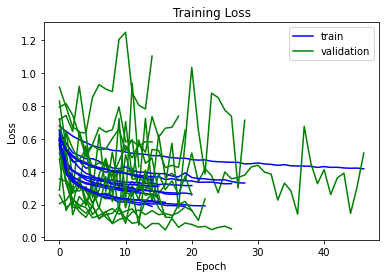

In [21]:
all_train_acc = list()
all_test_acc = list()
all_train_f1 = list()
all_test_f1 = list()
all_train_precision = list()
all_test_precision = list()
all_train_recall = list()
all_test_recall = list()

for i in range(15):
    datasets = [p1, p2, p3, p5, p6, p7, p8, p9, p10, p11, p12, p13, p14, p15, p16]
    data_train = datasets[i][:int(3*len(datasets[i])/4), :]
    data_test = datasets[i][:int(3*len(datasets[i])/4), :]
    
    rus = RandomUnderSampler()
    X_res, y_res = rus.fit_resample(data_train[:,:-1], data_train[:,-1])
    
    loss, val_loss, train_acc, test_acc, train_f1_score, test_f1_score, train_precision, test_precision, train_recall, test_recall = DNN(files[i], X_res, data_test[:,:-1], y_res, data_test[:,-1])
    
    all_train_acc.append(train_acc)
    all_test_acc.append(test_acc)
    all_train_f1.append(train_f1_score)
    all_test_f1.append(test_f1_score)
    all_train_precision.append(train_precision)
    all_test_precision.append(test_precision)
    all_train_recall.append(train_recall)
    all_test_recall.append(test_recall)

    # plot training history
    plt.plot(loss, label='train', color='b')
    plt.plot(val_loss, label='validation', color='g')
        
    print(f'Train {i}: {train_acc:.3f}, Test {files[i]}: {test_acc:.3f}')
    
plt.title('Training Loss')
plt.legend(['train', 'validation'])
plt.savefig('images/TrainingLoss_ind.pdf')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

The algorithm managed to learn for a longer time generally.

In [22]:
measures = [
    'Train Accuracy',
    'Test Accuracy',
    'Train Precision Score', 
    'Test Precision Score',
    'Train Recall Score',
    'Test Recall Score',
    'Train F1 Score',
    'Test F1 Score'
]
all_lists = [all_train_acc, all_test_acc, all_train_precision, all_test_precision, all_train_recall, all_test_recall, all_train_f1, all_test_f1]

for i in range(0, len(all_lists), 2):
    print(f"Average {measures[i]} = {np.array(all_lists[i]).mean():.3} +- {np.array(all_lists[i]).std():.3}")
    
print("====================")    

for i in range(1, len(all_lists)+1, 2):
    print(f"Average {measures[i]} = {np.array(all_lists[i]).mean():.3} +- {np.array(all_lists[i]).std():.3}")

Average Train Accuracy = 0.82 +- 0.12
Average Train Precision Score = 0.778 +- 0.117
Average Train Recall Score = 0.955 +- 0.0368
Average Train F1 Score = 0.85 +- 0.0732
Average Test Accuracy = 0.731 +- 0.211
Average Test Precision Score = 0.461 +- 0.184
Average Test Recall Score = 0.955 +- 0.0368
Average Test F1 Score = 0.598 +- 0.175


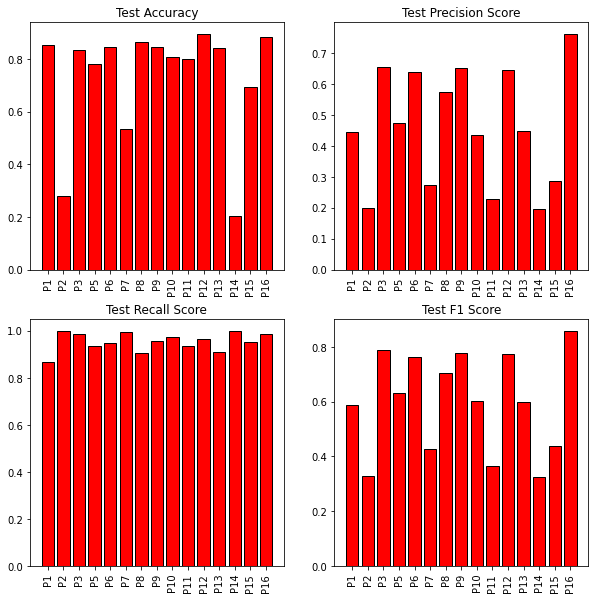

In [23]:
files = [f"P{n}" for n in range(1,17)]
files.remove("P4")
plt.figure(figsize=(10, 10))
for i, j in enumerate(list(range(1,len(all_lists)+1,2))):
    plt.subplot(2,2,i+1)
    plt.bar(files, all_lists[j], color='r', edgecolor='black')
    plt.title(measures[j])
    plt.xticks(rotation=90)
plt.savefig('images/scoreboard_ind.pdf')
plt.show()

### 6.2 LSTM

#### 6.2.1 Balacing Data

In [6]:
# Input

data_train, data_test = train_test_Xy_lstm([p1, p2], [p6])
print(f"Train data shape is {data_train.shape}")
print(f"Test data shape is {data_test.shape}")

Train data shape is (100095, 30, 4)
Test data shape is (54288, 30, 4)


In [7]:
print('Original dataset shape %s' % Counter(data_train[:,:,-1].reshape(-1)))

Original dataset shape Counter({0.0: 2508301, 1.0: 494549})


In [8]:
def balance_data(data_train):
    np.random.seed(7)

    N_negatives = Counter(data_train[:,:,-1].reshape(-1))[0.0]/30
    N_positives = Counter(data_train[:,:,-1].reshape(-1))[1.0]/30
    bal_n = int(N_negatives - N_positives)
    indexes = np.where(data_train[:,:,-1].mean(axis=1)==1.)[0]

    for i in range(int(bal_n/len(indexes))+1):
        data_train = np.concatenate((data_train, data_train[indexes]))
    return data_train

data_train = balance_data(data_train)

In [9]:
print('Original dataset shape %s' % Counter(data_train[:,:,-1].reshape(-1)))

Original dataset shape Counter({1.0: 2797499, 0.0: 2508301})


In [18]:
files = [f"all-one-lstm-test/P{n}" for n in range(1,6)]
files.remove("all-one-lstm-test/P4")
files

['all-one-lstm-test/P1',
 'all-one-lstm-test/P2',
 'all-one-lstm-test/P3',
 'all-one-lstm-test/P5']

#### 6.2.2 Model

In [12]:
def b_LSTM(file, X_train, X_test, y_train, y_test):
    
    window = 30
    
    model_path = os.path.join('models', f'{file}_lstm.h5')
    history_path = os.path.join('models', f'{file}_lstm.csv')
    
    if not os.path.isfile(model_path) or not os.path.isfile(history_path):
        model = Sequential()
        model.add(Bidirectional(LSTM(100, kernel_constraint=tf.keras.constraints.max_norm(5.), return_sequences=True, activation='relu'), input_shape=(window, 3)))
        model.add(TimeDistributed(Dense(1, activation='sigmoid')))

        lr=0.000005

        opt = Adagrad(learning_rate=lr)

        model.compile(
            optimizer=opt,
            loss='binary_crossentropy',
            metrics=['accuracy', f1_m],
        )

        es = EarlyStopping(monitor='val_f1_m', mode='max', verbose=0, patience=5)
        mc = ModelCheckpoint(model_path, monitor='val_f1_m', mode='max', verbose=0, save_best_only=True)
        
        history = model.fit(
            x=X_train,
            y=y_train,
            batch_size=150,
            epochs=50,
            verbose=1,
            validation_split=0.1,
            callbacks=[es, mc],
            shuffle=True,
        )
        history = pd.DataFrame(history.history)
        history.to_csv(history_path)
    
    history = pd.read_csv(history_path)
    model = load_model(model_path, custom_objects={'f1_m': f1_m})

    
    
    # evaluate the model
    yhat_train = (model.predict(X_train, batch_size=50, verbose=0) > 0.5).astype("int32")
    yhat_test = (model.predict(X_test, batch_size=50, verbose=0) > 0.5).astype("int32")
    
    y_train = y_train.reshape(-1)
    y_test = y_test.reshape(-1)
    yhat_train = yhat_train.reshape(-1)
    yhat_test = yhat_test.reshape(-1)
    
    # accuracy: (tp + tn) / (p + n)
    train_acc = accuracy_score(y_train, yhat_train)
    test_acc = accuracy_score(y_test, yhat_test)
    # precision tp / (tp + fp)
    train_precision = precision_score(y_train, yhat_train)
    test_precision = precision_score(y_test, yhat_test)
    # recall: tp / (tp + fn)
    train_recall = recall_score(y_train, yhat_train)
    test_recall = recall_score(y_test, yhat_test)
    # f1: 2 tp / (2 tp + fp + fn)
    train_f1_score = f1_score(y_train, yhat_train)
    test_f1_score = f1_score(y_test, yhat_test)
    
    return history['loss'], history['val_loss'], train_acc, test_acc, train_f1_score, test_f1_score, train_precision, test_precision, train_recall, test_recall

#### 6.2.3 Patient KFold

Train 0: 0.581, Test all-one-lstm-test/P1: 0.597
Train 1: 0.530, Test all-one-lstm-test/P2: 0.776
Train 2: 0.580, Test all-one-lstm-test/P3: 0.519
Train 3: 0.597, Test all-one-lstm-test/P5: 0.461


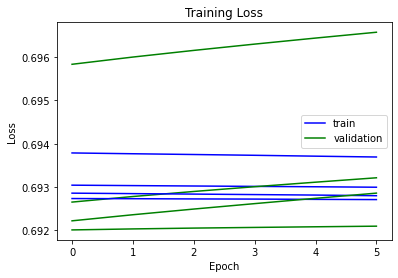

In [19]:
all_train_acc = list()
all_test_acc = list()
all_train_f1 = list()
all_test_f1 = list()
all_train_precision = list()
all_test_precision = list()
all_train_recall = list()
all_test_recall = list()

for i in range(4):
    datasets = [p1, p2, p3, p5]
    data_test = [datasets[i]]
    del datasets[i]
    
    data_train, data_test = train_test_Xy_lstm(datasets, data_test)
    
    data_train = balance_data(data_train)
    
    X_train = data_train[:,:,:-1]
    y_train = data_train[:,:,-1:]
    X_test = data_test[:,:,:-1]
    y_test = data_test[:,:,-1:]
    
    loss, val_loss, train_acc, test_acc, train_f1_score, test_f1_score, train_precision, test_precision, train_recall, test_recall = b_LSTM(files[i], X_train, X_test, y_train, y_test)
    
    all_train_acc.append(train_acc)
    all_test_acc.append(test_acc)
    all_train_f1.append(train_f1_score)
    all_test_f1.append(test_f1_score) 
    all_train_precision.append(train_precision)
    all_test_precision.append(test_precision)
    all_train_recall.append(train_recall)
    all_test_recall.append(test_recall)

    # plot training history
    plt.plot(loss, label='train', color='b')
    plt.plot(val_loss, label='validation', color='g')
        
    print(f'Train {i}: {train_acc:.3f}, Test {files[i]}: {test_acc:.3f}')
    
plt.title('Training Loss')
plt.legend(['train', 'validation'])
plt.savefig('images/TrainingLoss_LSTM.pdf')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [146]:
measures = [
    'Train Accuracy',
    'Test Accuracy',
    'Train Precision Score', 
    'Test Precision Score',
    'Train Recall Score',
    'Test Recall Score',
    'Train F1 Score',
    'Test F1 Score'
]
all_lists = [all_train_acc, all_test_acc, all_train_precision, all_test_precision, all_train_recall, all_test_recall, all_train_f1, all_test_f1]

for i in range(0, len(all_lists), 2):
    print(f"Average {measures[i]} = {np.array(all_lists[i]).mean():.3} +- {np.array(all_lists[i]).std():.3}")
    
print("====================")    

for i in range(1, len(all_lists)+1, 2):
    print(f"Average {measures[i]} = {np.array(all_lists[i]).mean():.3} +- {np.array(all_lists[i]).std():.3}")

Average Train Accuracy = 0.572 +- 0.0252
Average Train Precision Score = 0.652 +- 0.0919
Average Train Recall Score = 0.527 +- 0.239
Average Train F1 Score = 0.523 +- 0.184
Average Test Accuracy = 0.588 +- 0.119
Average Test Precision Score = 0.27 +- 0.0723
Average Test Recall Score = 0.516 +- 0.265
Average Test F1 Score = 0.289 +- 0.121


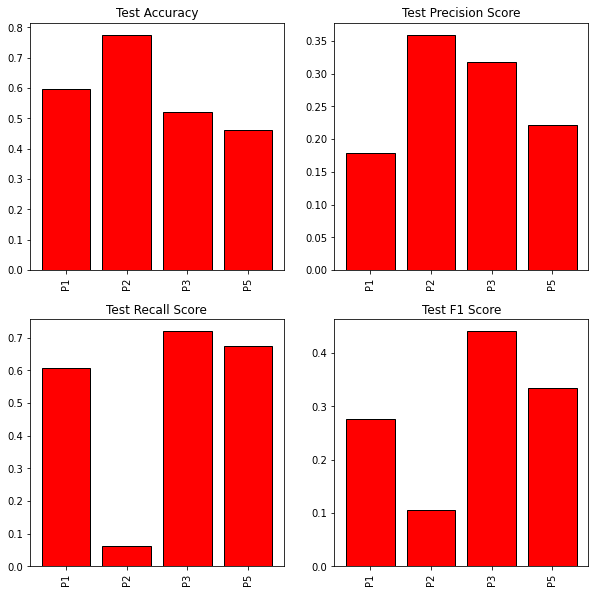

In [148]:
files = [f"P{n}" for n in range(1,6)]
files.remove("P4")
plt.figure(figsize=(10, 10))
for i, j in enumerate(list(range(1,len(all_lists)+1,2))):
    plt.subplot(2,2,i+1)
    plt.bar(files, all_lists[j], color='r', edgecolor='black')
    plt.title(measures[j])
    plt.xticks(rotation=90)
plt.savefig('images/scoreboard_lstm.pdf')
plt.show()